# Title: Severity of road traffic accidents

In [ ]:
%load_ext watermark
%watermark -a "Van Wu" -u -d -t -v -p numpy,pandas,matplotlib,scikit-learn

## Preparation

- [Github link](https://github.com/Van-Wu1/0006.git)

- Number of words: ***

- Runtime: *** hours (*Memory 32 GB, CPU AMD Ryzen 7 5800H with Radeon Graphics CPU @3.20GHz*)

- Coding environment: Coding environment: VS Code with Jupyter plugin (local), not SDS Docker

- License: this notebook is made available under the [Creative Commons Attribution license](https://creativecommons.org/licenses/by/4.0/).

- Additional library *[libraries not included in SDS Docker or not used in this module]*:
    - **watermark**: A Jupyter Notebook extension for printing timestamps, version numbers, and hardware information.(used to print Python and package versions for reproducibility.)
    - ......

## Table of contents

1. [Introduction](#Introduction)

1. [Research questions](#Research-questions)

1. [Data](#Data)

1. [Methodology](#Methodology)

1. [Results and discussion](#Results-and-discussion)

1. [Conclusion](#Conclusion)

1. [References](#References)

## Introduction

[[ go back to the top ]](#Table-of-contents)

## Research questions

[[ go back to the top ]](#Table-of-contents)

## Data

[[ go back to the top ]](#Table-of-contents)

### 1. Data Description

| Variable                                  | Type         | Description                                                                                  | Notes                        |
|-------------------------------------------|--------------|----------------------------------------------------------------------------------------------|------------------------------|
| accident_severity                       | Categorical  | Severity level of the accident (e.g., slight, serious, fatal)                                | Target variable              |
| number_of_vehicles                      | Numeric      | Number of vehicles involved in the accident                                                  | -                            |
| number_of_casualties                    | Numeric      | Number of casualties involved                                                                | -                            |
| day_of_week                             | Categorical  | Day of the week when the accident occurred (1 = Sunday, ..., 7 = Saturday)                   | One-hot encoding recommended |
| time_hour (derived from time)         | Numeric      | Hour of the day when the accident occurred (e.g., 13:55 → 13)                                | Derived feature              |
| first_road_class                        | Categorical  | Classification of the primary road (1–6, denoting different road types)                      | Ordinal/Categorical          |
| second_road_class                       | Categorical  | Classification of the secondary road                                                         | -                            |
| road_type                               | Categorical  | Type of road (e.g., one-way, dual carriageway, roundabout)                                   | One-hot encoding             |
| speed_limit                             | Numeric      | Speed limit of the road segment (in mph)                                                     | -                            |
| junction_detail                         | Categorical  | Structural detail of the junction                                                            | -                            |
| junction_control                        | Categorical  | Type of junction control (e.g., traffic signal, give way sign)                               | -                            |
| pedestrian_crossing_human_control       | Categorical  | Presence of human-controlled pedestrian crossing                                             | Binary/Categorical           |
| pedestrian_crossing_physical_facilities | Categorical  | Presence of physical pedestrian crossing facilities (e.g., zebra crossing)                   | -                            |
| light_conditions                        | Categorical  | Lighting conditions at the time of the accident                                              | -                            |
| weather_conditions                      | Categorical  | Weather conditions during the accident (e.g., fine, rain, fog)                               | -                            |
| road_surface_conditions                 | Categorical  | Road surface conditions (e.g., dry, wet, icy)                                                | -                            |
| special_conditions_at_site              | Categorical  | Special conditions at the accident site (e.g., roadworks, closure)                           | -                            |
| carriageway_hazards                     | Categorical  | Presence of carriageway hazards (e.g., spillages, obstructions)                              | -                            |
| urban_or_rural_area                     | Categorical  | Whether the area is urban or rural (1 = Urban, 2 = Rural)                                    | Binary (urban = 1)           |
| did_police_officer_attend_scene_of_accident | Categorical  | Whether a police officer attended the scene of the accident                                  | Binary                       |
| trunk_road_flag                         | Categorical  | Whether the accident occurred on a trunk road                                                | Binary                       |
| local_authority_ons_district            | Categorical  | ONS code of the local authority district; useful for spatial join with external datasets     | Useful for joining external data |


### 2. Data Import and Prepration

In [1]:
# It would import the packages that would be used first. 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import os
import osmnx as ox
import networkx as nx
import geopandas as gpd
from tqdm import tqdm

input_folder = '../data/raw'
output_folder = '../data/clean'

In [ ]:
# Road Data
columns_to_keep = [
    'accident_severity',
    'number_of_vehicles',
    'number_of_casualties',
    'day_of_week',
    'time',
    'first_road_class',
    'second_road_class',
    'road_type',
    'speed_limit',
    'junction_detail',
    'junction_control',
    'pedestrian_crossing_human_control',
    'pedestrian_crossing_physical_facilities',
    'light_conditions',
    'weather_conditions',
    'road_surface_conditions',
    'special_conditions_at_site',
    'carriageway_hazards',
    'urban_or_rural_area',
    'did_police_officer_attend_scene_of_accident',
    'trunk_road_flag',
    'local_authority_ons_district'
]

files = {
    '2019.csv': '2019_cleaned.csv',
    '2020.csv': '2020_cleaned.csv',
    '2021.csv': '2021_cleaned.csv',
    '2022.csv': '2022_cleaned.csv',
    '2023.csv': '2023_cleaned.csv'
    # '2024_unvalidated.csv': '2024_cleaned.csv'
}

for input_file, output_file in files.items():
    input_path = os.path.join(input_folder, input_file)
    df = pd.read_csv(input_path)

    selected_columns = [col for col in columns_to_keep if col in df.columns]
    df_cleaned = df[selected_columns]

    # ✅ 检查缺失值
    missing_counts = df_cleaned.isnull().sum()
    total_missing = missing_counts.sum()

    if total_missing > 0:
        print(f"⚠️  {output_file} has {total_missing} missing values:")
        print(missing_counts[missing_counts > 0])
        
        # 自动丢弃含缺失值的行
        # df_cleaned = df_cleaned.dropna()
        # print(f"✅ Dropped rows with missing values. Remaining rows: {len(df_cleaned)}")

    output_path = os.path.join(output_folder, output_file)
    df_cleaned.to_csv(output_path, index=False)
    print(f"✅ {output_file} has been saved in {output_path}, containing {len(df_cleaned.columns)} fields, for {len(df_cleaned)} records.\n")


df_2019 = pd.read_csv('../data/clean/2019_cleaned.csv')
df_2020 = pd.read_csv('../data/clean/2020_cleaned.csv')
df_2021 = pd.read_csv('../data/clean/2021_cleaned.csv')
df_2022 = pd.read_csv('../data/clean/2022_cleaned.csv')
df_2023 = pd.read_csv('../data/clean/2023_cleaned.csv')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_26816\1467772147.py:38: DtypeWarning: Columns (0,2,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_path)


✅ 2019_cleaned.csv has been saved in ../data/clean\2019_cleaned.csv, containing 22 fields, for 117536 records.



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_26816\1467772147.py:38: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_path)


✅ 2020_cleaned.csv has been saved in ../data/clean\2020_cleaned.csv, containing 22 fields, for 91199 records.



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_26816\1467772147.py:38: DtypeWarning: Columns (0,2,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_path)


✅ 2021_cleaned.csv has been saved in ../data/clean\2021_cleaned.csv, containing 22 fields, for 101087 records.



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_26816\1467772147.py:38: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_path)


✅ 2022_cleaned.csv has been saved in ../data/clean\2022_cleaned.csv, containing 22 fields, for 106004 records.



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_26816\1467772147.py:38: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_path)


✅ 2023_cleaned.csv has been saved in ../data/clean\2023_cleaned.csv, containing 22 fields, for 104258 records.



In [ ]:
# RoadCentrality
path = "../data/Borough_Boundaries.geojson"
boroughs = gpd.read_file(path)
boroughs = boroughs[["name", "gss_code", "geometry"]].rename(columns={"name": "borough"})

ox.settings.log_console = False
ox.settings.use_cache = True

results = []

for idx, row in tqdm(boroughs.iterrows(), total=len(boroughs), desc="Processing boroughs"):
    borough_name = row["borough"]
    gss_name = row["gss_code"]   
    geometry = row["geometry"]

    try:
        print(f"🚦 Processing: {borough_name}")
        
        G = ox.graph_from_polygon(geometry, network_type="drive", simplify=True)

        betweenness = nx.betweenness_centrality(G, weight="length", k=100, seed=42)
        degree = dict(G.degree())
        nx.set_node_attributes(G, betweenness, "betweenness")
        nx.set_node_attributes(G, degree, "degree")

        edge_data = []
        for u, v, key, data in G.edges(keys=True, data=True):
            edge_data.append({
                "u": u,
                "v": v,
                "key": key,
                "geometry": data.get("geometry", None),
                "betweenness": (G.nodes[u]["betweenness"] + G.nodes[v]["betweenness"]) / 2,
                "degree": (G.nodes[u]["degree"] + G.nodes[v]["degree"]) / 2
            })
        edges_df = gpd.GeoDataFrame(edge_data, geometry="geometry", crs="EPSG:4326")

        summary = {
            "borough": borough_name,
            "gss_code": gss_name,
            "mean_betweenness": edges_df["betweenness"].mean(),
            "max_betweenness": edges_df["betweenness"].max(),
            "mean_degree": edges_df["degree"].mean(),
            "max_degree": edges_df["degree"].max(),
            "edge_count": len(edges_df)
        }
        results.append(summary)

    except Exception as e:
        print(f"❌ Failed for {borough_name}: {e}")
        continue

df_results = pd.DataFrame(results)
df_results.to_csv("../data/london_borough_road_centrality.csv", index=False)
print("All done! Results saved to 'london_borough_road_centrality.csv'")

Processing boroughs:   0%|          | 0/33 [00:00<?, ?it/s]

🚦 Processing: Kingston upon Thames


Processing boroughs:   3%|▎         | 1/33 [00:05<02:54,  5.45s/it]

🚦 Processing: Croydon


Processing boroughs:   6%|▌         | 2/33 [00:19<05:17, 10.24s/it]

🚦 Processing: Bromley


Processing boroughs:   9%|▉         | 3/33 [00:33<06:02, 12.07s/it]

🚦 Processing: Hounslow


Processing boroughs:  12%|█▏        | 4/33 [00:42<05:14, 10.85s/it]

🚦 Processing: Ealing


Processing boroughs:  15%|█▌        | 5/33 [00:51<04:49, 10.35s/it]

🚦 Processing: Havering


Processing boroughs:  18%|█▊        | 6/33 [01:00<04:26,  9.88s/it]

🚦 Processing: Hillingdon


Processing boroughs:  21%|██        | 7/33 [01:13<04:39, 10.76s/it]

🚦 Processing: Harrow


Processing boroughs:  24%|██▍       | 8/33 [01:19<03:56,  9.46s/it]

🚦 Processing: Brent


Processing boroughs:  27%|██▋       | 9/33 [01:27<03:36,  9.00s/it]

🚦 Processing: Barnet


Processing boroughs:  30%|███       | 10/33 [01:40<03:48,  9.94s/it]

🚦 Processing: Lambeth


Processing boroughs:  33%|███▎      | 11/33 [01:48<03:31,  9.60s/it]

🚦 Processing: Southwark


Processing boroughs:  36%|███▋      | 12/33 [01:57<03:16,  9.34s/it]

🚦 Processing: Lewisham


Processing boroughs:  39%|███▉      | 13/33 [02:05<03:00,  9.02s/it]

🚦 Processing: Greenwich


Processing boroughs:  42%|████▏     | 14/33 [02:16<03:03,  9.64s/it]

🚦 Processing: Bexley


Processing boroughs:  45%|████▌     | 15/33 [02:25<02:49,  9.42s/it]

🚦 Processing: Enfield


Processing boroughs:  48%|████▊     | 16/33 [02:36<02:44,  9.68s/it]

🚦 Processing: Waltham Forest


Processing boroughs:  52%|█████▏    | 17/33 [02:42<02:21,  8.81s/it]

🚦 Processing: Redbridge


Processing boroughs:  55%|█████▍    | 18/33 [02:51<02:09,  8.62s/it]

🚦 Processing: Sutton


Processing boroughs:  58%|█████▊    | 19/33 [02:58<01:53,  8.11s/it]

🚦 Processing: Richmond upon Thames


Processing boroughs:  61%|██████    | 20/33 [03:06<01:45,  8.08s/it]

🚦 Processing: Merton


Processing boroughs:  64%|██████▎   | 21/33 [03:12<01:32,  7.70s/it]

🚦 Processing: Wandsworth


Processing boroughs:  67%|██████▋   | 22/33 [03:21<01:29,  8.12s/it]

🚦 Processing: Hammersmith and Fulham


Processing boroughs:  70%|██████▉   | 23/33 [03:26<01:09,  6.93s/it]

🚦 Processing: Kensington and Chelsea


Processing boroughs:  73%|███████▎  | 24/33 [03:29<00:54,  6.02s/it]

🚦 Processing: Westminster


Processing boroughs:  76%|███████▌  | 25/33 [03:37<00:50,  6.33s/it]

🚦 Processing: Camden


Processing boroughs:  79%|███████▉  | 26/33 [03:43<00:43,  6.23s/it]

🚦 Processing: Tower Hamlets


Processing boroughs:  82%|████████▏ | 27/33 [03:50<00:39,  6.58s/it]

🚦 Processing: Islington


Processing boroughs:  85%|████████▍ | 28/33 [03:55<00:31,  6.27s/it]

🚦 Processing: Hackney


Processing boroughs:  88%|████████▊ | 29/33 [04:02<00:24,  6.20s/it]

🚦 Processing: Haringey


Processing boroughs:  91%|█████████ | 30/33 [04:08<00:18,  6.18s/it]

🚦 Processing: Newham


Processing boroughs:  94%|█████████▍| 31/33 [04:16<00:13,  6.85s/it]

🚦 Processing: Barking and Dagenham


Processing boroughs:  97%|█████████▋| 32/33 [04:22<00:06,  6.48s/it]

🚦 Processing: City of London


Processing boroughs: 100%|██████████| 33/33 [04:24<00:00,  8.00s/it]


OSError: Cannot save file into a non-existent directory: 'data'

In [ ]:
#Join
# 设置路径
accident_folder = "../data/clean"
centrality_path = "../data/london_borough_road_centrality.csv"
data_with_centrality = "../data/final"

# 读取道路中心性数据
df_centrality = pd.read_csv(centrality_path)

# 循环处理每一年
for year in range(2019, 2024):  # 2019–2023
    accident_file = f"{year}_cleaned.csv"
    accident_path = os.path.join(accident_folder, accident_file)

    if not os.path.exists(accident_path):
        print(f"❌ File not found: {accident_path}")
        continue

    # 读取事故数据
    df_accident = pd.read_csv(accident_path)

    # 合并中心性数据
    df_merged = df_accident.merge(
        df_centrality,
        how="left",
        left_on="local_authority_ons_district",
        right_on="gss_code"
    )

    # 删除没有中心性值的行（非伦敦地区）
    before_drop = len(df_merged)
    df_merged = df_merged.dropna(subset=["mean_betweenness"])
    after_drop = len(df_merged)
    dropped = before_drop - after_drop

    # 输出文件
    output_path = os.path.join(data_with_centrality, f"{year}_with_centrality.csv")
    df_merged.to_csv(output_path, index=False)

    print(f"✅ {year} saved with centrality! Rows kept: {after_drop}, dropped: {dropped}")

✅ 2019 saved with centrality! Rows kept: 25310, dropped: 92226
✅ 2020 saved with centrality! Rows kept: 20996, dropped: 70203
✅ 2021 saved with centrality! Rows kept: 23127, dropped: 77960
✅ 2022 saved with centrality! Rows kept: 23477, dropped: 82527
✅ 2023 saved with centrality! Rows kept: 22895, dropped: 81363


In [ ]:
import pandas as pd
import os

# 定义年份和路径
years = [2019, 2020, 2021, 2022, 2023]
dfs = []

for year in years:
    path = f"../data/final/{year}_with_centrality.csv"
    if os.path.exists(path):
        df = pd.read_csv(path)
        df["year"] = year  # ✅ 添加年份列
        dfs.append(df)
    else:
        print(f"❌ File not found: {path}")

# 合并所有年份数据
df_all = pd.concat(dfs, ignore_index=True)
df_all.to_csv("../data/final/all_years_with_centrality.csv", index=False)


### 3. Data Pattern Analysis

In [29]:
df = df_all

In [30]:
print(df.shape)
print(df.dtypes)
print(df.isnull().sum())   # 缺失值检查
df.describe()              # 数值特征统计
df["accident_severity"].value_counts(normalize=True)  # 类别分布

(115805, 30)
accident_severity                                int64
number_of_vehicles                               int64
number_of_casualties                             int64
day_of_week                                      int64
time                                            object
first_road_class                                 int64
second_road_class                                int64
road_type                                        int64
speed_limit                                      int64
junction_detail                                  int64
junction_control                                 int64
pedestrian_crossing_human_control                int64
pedestrian_crossing_physical_facilities          int64
light_conditions                                 int64
weather_conditions                               int64
road_surface_conditions                          int64
special_conditions_at_site                       int64
carriageway_hazards                              int

accident_severity
3    0.847796
2    0.147982
1    0.004223
Name: proportion, dtype: float64

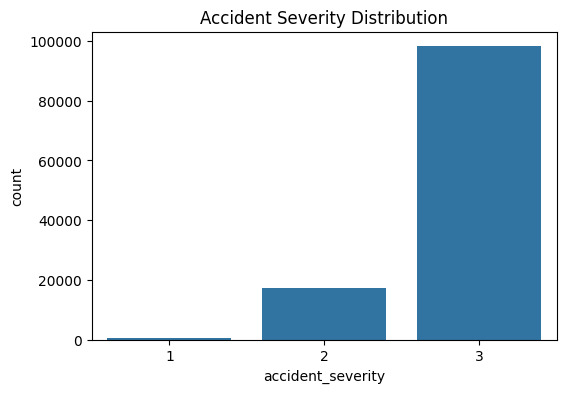

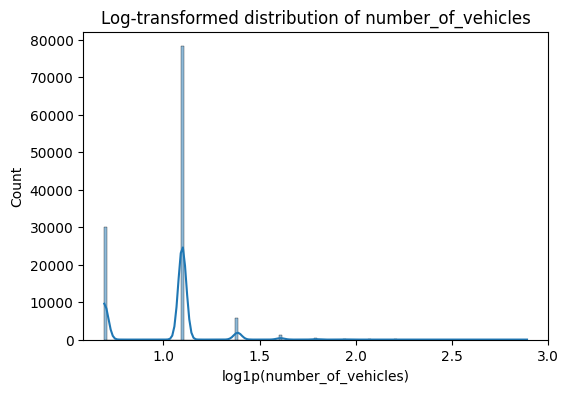

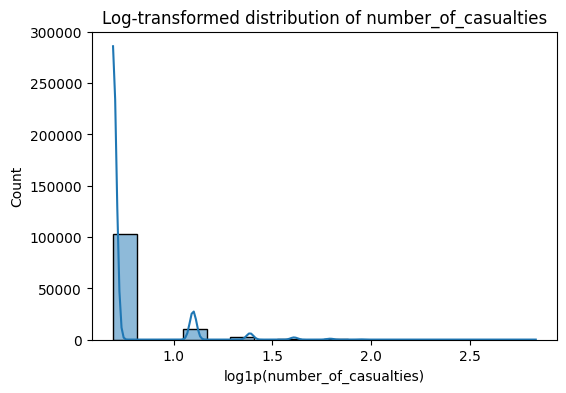

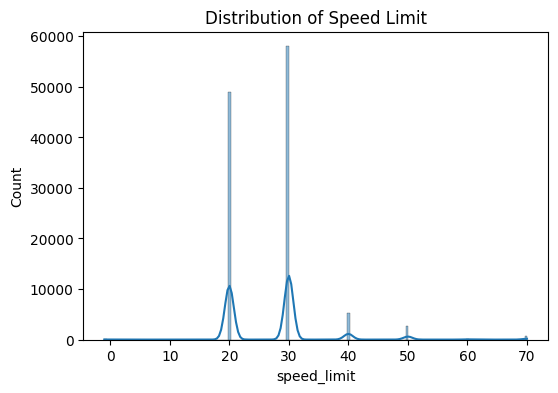

In [37]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 事故严重程度分布
plt.figure(figsize=(6,4))
sns.countplot(x="accident_severity", data=df)
plt.title("Accident Severity Distribution")
plt.show()


# 数值型：车数、伤亡数、限速
for col in ["number_of_vehicles", "number_of_casualties"]:
    plt.figure(figsize=(6, 4))
    sns.histplot(np.log1p(df[col]), kde=True)  # log1p(x) = log(x + 1)，避免 log(0) 报错
    plt.title(f"Log-transformed distribution of {col}")
    plt.xlabel(f"log1p({col})")
    plt.ylabel("Count")
    plt.show()

plt.figure(figsize=(6, 4))
sns.histplot(df["speed_limit"], kde=True)
plt.title("Distribution of Speed Limit")
plt.xlabel("speed_limit")
plt.ylabel("Count")
plt.show()


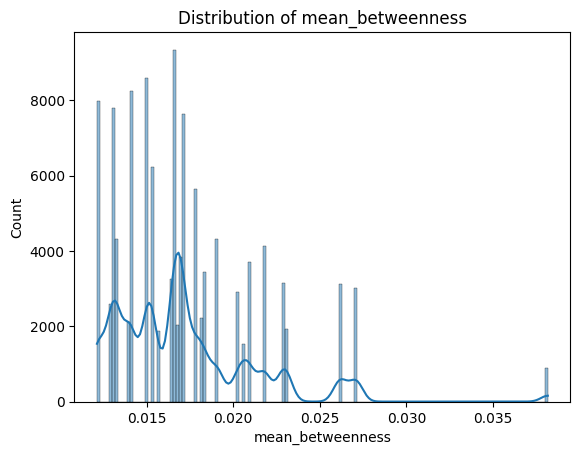

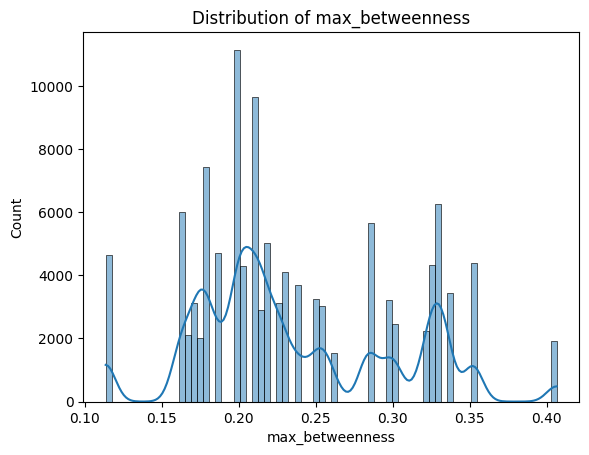

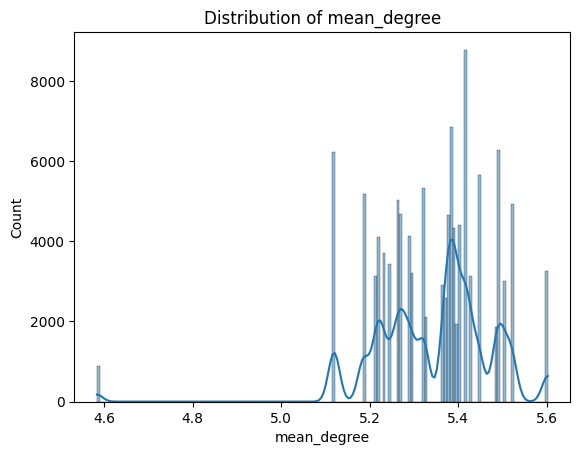

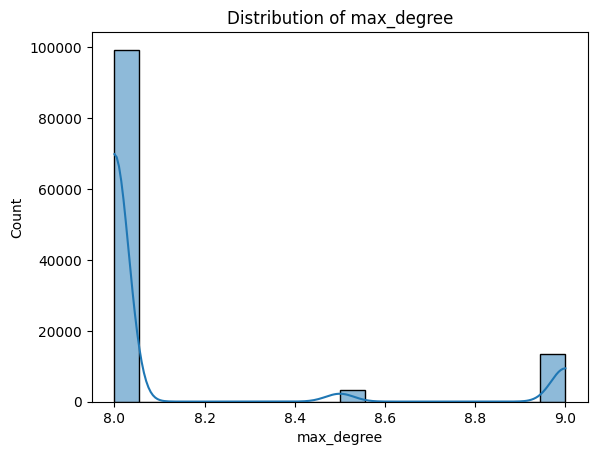

In [32]:
# 中心性变量分布（单变量 + 空值检查）
for col in ["mean_betweenness", "max_betweenness", "mean_degree", "max_degree"]:
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

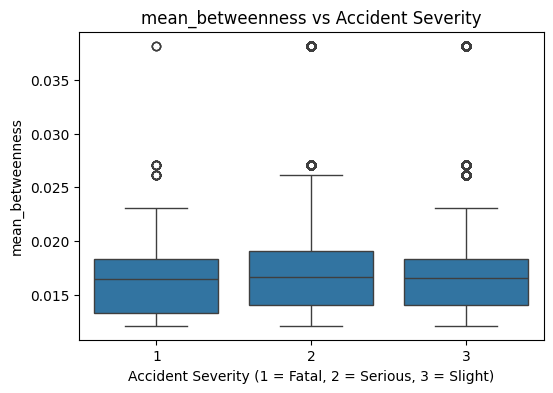

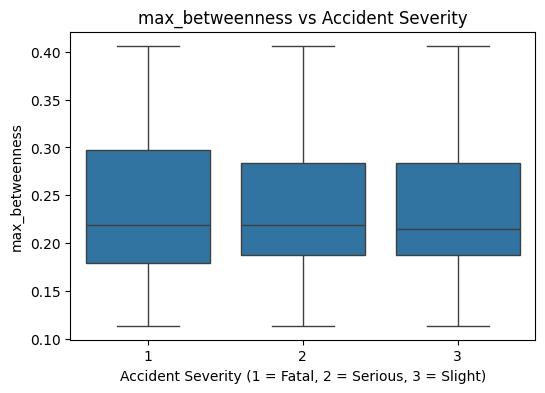

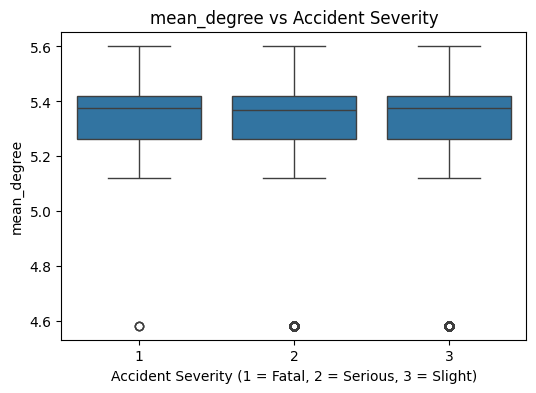

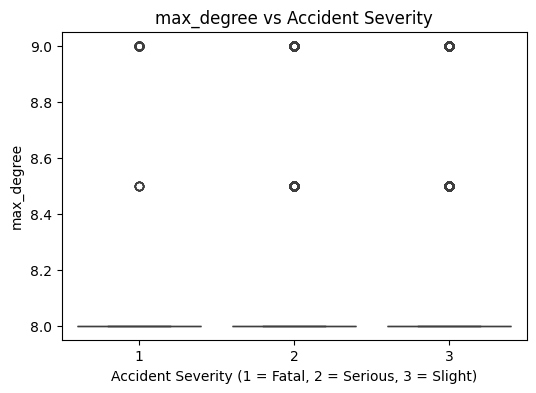

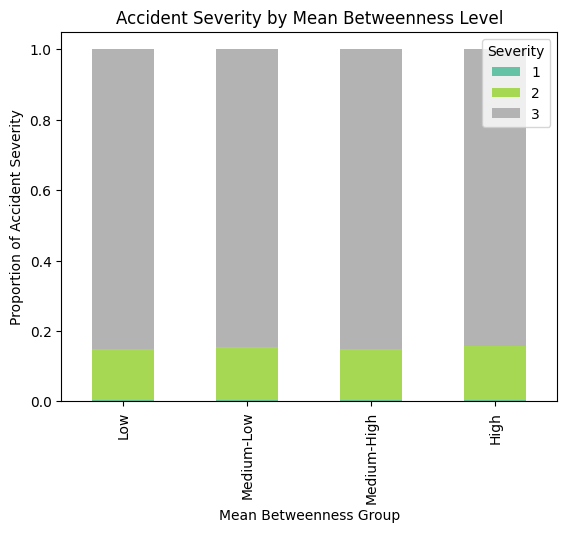

Text(0.5, 1.0, 'Accident Severity by Day of Week')

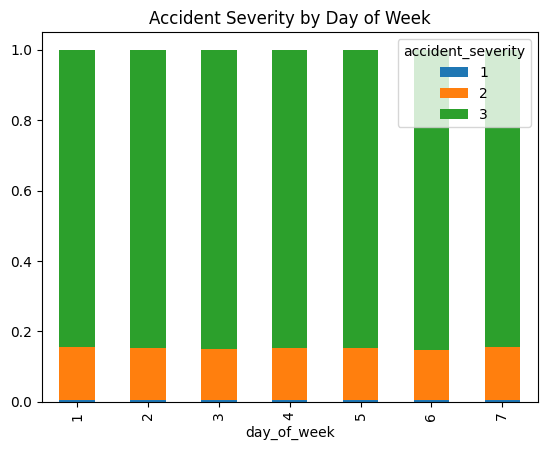

In [38]:
# 变量与事故严重程度的关系（双变量分析）
for col in ["mean_betweenness", "max_betweenness", "mean_degree", "max_degree"]:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x="accident_severity", y=col, data=df_all)
    plt.title(f"{col} vs Accident Severity")
    plt.xlabel("Accident Severity (1 = Fatal, 2 = Serious, 3 = Slight)")
    plt.ylabel(col)
    plt.show()

# 将 mean_betweenness 分为 4 个等级（四分位）
df_all["betweenness_level"] = pd.qcut(df_all["mean_betweenness"], q=4, labels=["Low", "Medium-Low", "Medium-High", "High"])

# 查看每组的事故严重程度比例
severity_by_level = pd.crosstab(df_all["betweenness_level"], df_all["accident_severity"], normalize='index')

# 画分组堆叠条形图
severity_by_level.plot(kind="bar", stacked=True, colormap="Set2")
plt.title("Accident Severity by Mean Betweenness Level")
plt.xlabel("Mean Betweenness Group")
plt.ylabel("Proportion of Accident Severity")
plt.legend(title="Severity", loc="upper right")
plt.show()


# 类别型变量可交叉表分析：
pd.crosstab(df["day_of_week"], df["accident_severity"], normalize='index').plot(kind='bar', stacked=True)
plt.title("Accident Severity by Day of Week")

从箱线图和堆叠条形图可以看出，道路网络的最大中介中心性（max_betweenness）在不同事故严重程度之间具有更明显的区分度，尤其在致命事故中普遍更高。而平均中介中心性（mean_betweenness）则呈现轻微的变化，说明其在大尺度上影响有限，但仍具备潜在的建模价值。相比之下，度中心性（degree centrality）在不同类别中的分布差异不明显，解释力较弱。

According to the boxplots and grouped bar charts, maximum betweenness centrality (max_betweenness) shows stronger differentiation across accident severity levels, especially with higher values in fatal accidents. In contrast, mean_betweenness exhibits weaker variation, indicating a more subtle influence. Degree-based indicators, particularly max_degree, show very limited discriminative power and may not be useful in predictive modeling.

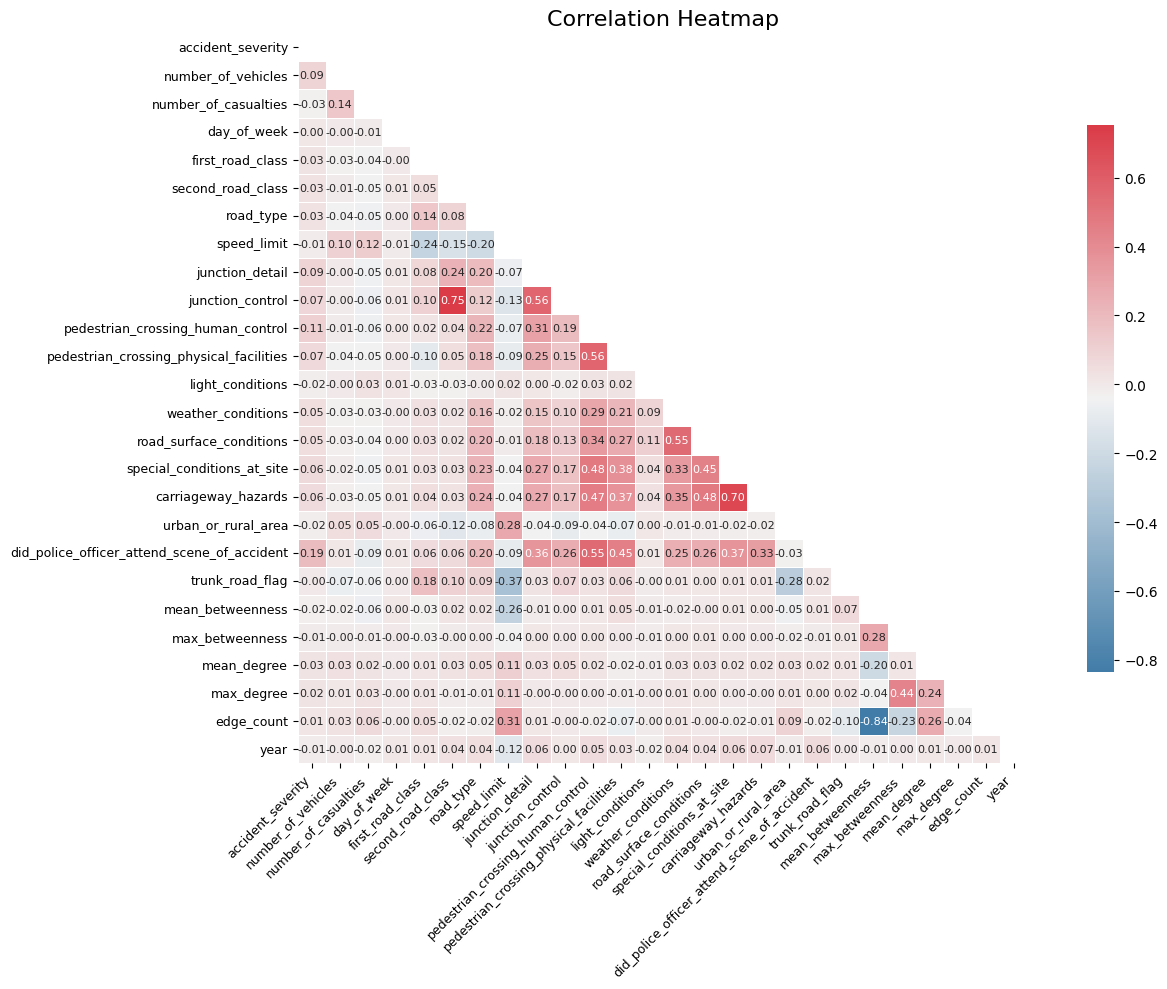

In [39]:
# 特征间相关性分析（热力图）

# 计算皮尔森相关矩阵
corr = df_all.corr(numeric_only=True)

# 设置画布大小
plt.figure(figsize=(14, 10))

# 只显示下三角
mask = np.triu(np.ones_like(corr, dtype=bool))

# 自定义调色盘
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# 画图
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 8},
    square=True,
    cbar_kws={"shrink": 0.75},
    linewidths=0.5
)

plt.title("Correlation Heatmap", fontsize=16)
plt.xticks(rotation=45, ha="right", fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()


从相关性热力图可以看出，大多数道路结构与环境变量与事故严重程度的线性相关性较弱，仅部分变量（如是否有警察到场、是否为主干道）呈现中等负相关关系（如 did_police_officer_attend_scene_of_accident = -0.19），表明事故越严重越可能有警察响应。此外，max_betweenness 与 accident_severity 虽然相关性不强（0.01），但考虑其在箱线图中展现的区分度，仍可能在非线性模型中具备解释力。

As shown in the correlation heatmap, most road network and contextual features exhibit low linear correlation with accident severity. However, certain variables such as police attendance and trunk road flag show moderate negative correlations (e.g., did_police_officer_attend_scene_of_accident = -0.19), indicating a higher likelihood of police presence in more severe accidents. While max_betweenness shows limited linear correlation, its value in nonlinear models remains promising, as evidenced in previous boxplot analyses.

在变量选择阶段，本研究采用了相关性分析与基于模型的重要性分析相结合的方法。尽管部分变量与目标变量之间的皮尔森相关系数较低，但在构建树模型（如 Random Forest、LightGBM）时仍予以保留，以捕捉可能存在的非线性结构或交互效应，从而提升模型整体性能。

To explore the relevance of different features with the accident severity, both correlation analysis and model-based feature importance were used. Although some features exhibited weak linear correlation with the target, they were retained for training in tree-based models (e.g., Random Forest, LightGBM), as such models can capture non-linear interactions and conditional dependencies that correlation cannot reflect.

## Methodology

[[ go back to the top ]](#Table-of-contents)

*[Note: a flow chart that describes the methodology is strongly encouraged - see the example below. This flow chart can be made using Microsoft powerpoint or visio or other software]*

Source: see [link](https://linkinghub.elsevier.com/retrieve/pii/S2210670722004437).

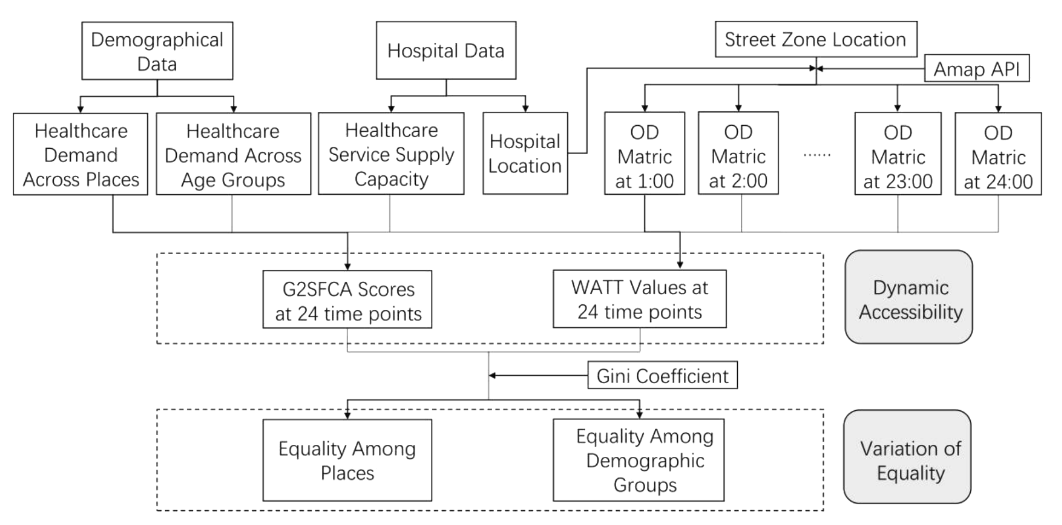

## Results and discussion

[[ go back to the top ]](#Table-of-contents)

## Conclusion

[[ go back to the top ]](#Table-of-contents)

## References

[[ go back to the top ]](#Table-of-contents)